In [ ]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from transformers import pipeline, AutoTokenizer, get_linear_schedule_with_warmup, AutoModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm
tqdm.pandas()
from IPython.display import clear_output

**Warning:**
Изначально данный ноутбук обучал модель `intfloat/multilingual-e5-small` предсказывать классифицировать пару предложений как последовательные. Однако такая версия ноутбука была утрачена и впоследствии заменена на бесполезный в контексте решения нашей задачи алгоритм формирования эмбеддингов через косинусное расстояние между парой предложений. 

Данная процедура обучения носит лишь практический характер, но не исследовательский.

In [2]:
path="../data/"
dataset = pd.read_csv(path+"nsp.csv")

train, test = train_test_split(dataset, test_size=0.2, random_state=1)
eval = test[:5000]
print(train.shape, test.shape)

print(train.columns)

(2365728, 3) (591432, 3)
Index(['start', 'next', 'label'], dtype='object')


In [3]:
device = 'cuda'

In [4]:
model_name = "intfloat/multilingual-e5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
print(type(model))

<class 'transformers.models.bert.modeling_bert.BertModel'>


In [5]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(250037, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

In [6]:
class NextSentenceDataset(Dataset):
    def __init__(self, data, tokenizer, device):
        self.start_sents = data['start']
        self.next_sents = data['next']
        self.labels = data['label']
        self.device = device
        self.tokenizer = tokenizer
        

    def __len__(self):
        return len(self.start_sents)

    def __getitem__(self, idx):
        start = self.start_sents.iloc[idx]
        next = self.next_sents.iloc[idx]
        label = self.labels.iloc[idx]

        start_encoding = self.tokenizer(
            start,
            truncation=True, padding='max_length',
            # max_length=self.max_len,
            return_tensors='pt'
        )
        next_encoding = self.tokenizer(
            next,
            truncation=True, padding='max_length',
            # max_length=self.max_len,
            return_tensors='pt'
        )
        label = -1 if label == 0 else label
        label = torch.tensor(label, device=self.device)

        start_encoding = {k: v.squeeze(0).to(self.device) for k, v in start_encoding.items()}
        next_encoding = {k: v.squeeze(0).to(self.device) for k, v in next_encoding.items()}

        return start_encoding, next_encoding, label

In [7]:
train_dataset = NextSentenceDataset(train, tokenizer, device)
eval_dataset = NextSentenceDataset(eval, tokenizer, device)
test_dataset = NextSentenceDataset(test, tokenizer, device)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

In [8]:
for batch in train_dataloader:
    print(batch)
    break

[{'input_ids': tensor([[     0,   6646,   2124,  ...,      1,      1,      1],
        [     0,  88606,    329,  ...,      1,      1,      1],
        [     0,    901,  48034,  ...,      1,      1,      1],
        ...,
        [     0,  16459,  28634,  ...,      1,      1,      1],
        [     0,     20,   4805,  ...,      1,      1,      1],
        [     0,  16459, 194583,  ...,      1,      1,      1]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}, {'input_ids': tensor([[     0,   4394,    178,  ...,      1,      1,      1],
        [     0,  16459,    363,  ...,      1,      1,      1],
        [     0,  16459,    647,  ...,      1,      1,      1],
        ...,
        [     0,    672, 156269,  ...,      1,      1,      1],
        [     0,   1031,

In [9]:
n_epochs = 1

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
total_steps = 10000
warmup_steps = 1
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)
loss_fn = torch.nn.CosineEmbeddingLoss()

In [10]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    print(f"Evaluating...")
    model.eval()
    model.to(device)

    total_loss = 0
    for j, batch in enumerate(tqdm(dataloader, position=1)):
        starts, nexts, labels = batch
        start_embeddings = model(**starts).pooler_output
        next_embeddings = model(**nexts).pooler_output
        loss = loss_fn(start_embeddings, next_embeddings, labels)
        total_loss += loss.item()

    model.train()
    
    return total_loss / len(dataloader)

    

def train_loop(model, train_dataloader, test_dataloader, n_epochs, device, optimizer, scheduler):
    model.train()
    model.to(device)

    losses = []
    eval_losses = []

    p_bar = tqdm(train_dataloader, position=0)

    for epoch in range(n_epochs):
        total_loss = 0
        for j, batch in enumerate(p_bar):
            if j == 0:
                eval_loss = evaluate(model, test_dataloader, device)
                eval_losses.append(eval_loss)
                plt.plot(eval_losses)
                plt.title("Eval losses")
                plt.show()

            starts, nexts, labels = batch
            optimizer.zero_grad()
            start_embeddings = model(**starts).pooler_output
            next_embeddings = model(**nexts).pooler_output
            loss = loss_fn(start_embeddings, next_embeddings, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            losses.append(loss.item())

            p_bar.set_postfix_str(f"lr: {scheduler.get_lr()[0]}, loss: {loss.item()}")

            if (j + 1) % 200 == 0:
                clear_output()
                plt.plot(losses)
                plt.title("Train losses")
                plt.show()

                eval_loss = evaluate(model, test_dataloader, device)
                eval_losses.append(eval_loss)
                plt.plot(eval_losses)
                plt.title("Eval losses")
                plt.show()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_dataloader)}")

    # Сохранение модели
    model.save_pretrained("./fine_tuned_nsp_e5")
    tokenizer.save_pretrained("./fine_tuned_nsp_e5")


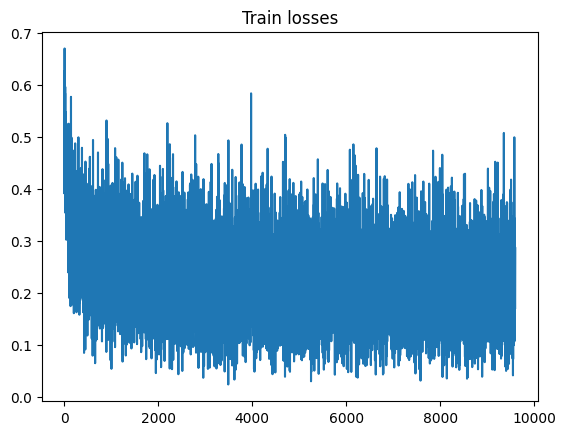

Evaluating...


100%|██████████| 312/312 [00:14<00:00, 21.08it/s]


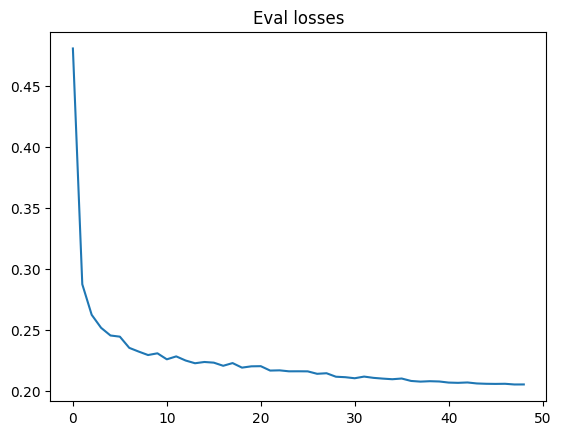

  7%|▋         | 9712/147858 [37:10<8:48:49,  4.35it/s, lr: 2.8802880288028806e-07, loss: 0.18648912012577057] 


KeyboardInterrupt: 

In [11]:
n_epochs = 1

model_name = "intfloat/multilingual-e5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
total_steps = 10000
warmup_steps = 1
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)
loss_fn = torch.nn.CosineEmbeddingLoss()

train_loop(model, train_dataloader, eval_dataloader, n_epochs, device, optimizer, scheduler)

In [13]:
model.save_pretrained("./fine_tuned_nsp_e5")
tokenizer.save_pretrained("./fine_tuned_nsp_e5")

('./fine_tuned_nsp_e5/tokenizer_config.json',
 './fine_tuned_nsp_e5/special_tokens_map.json',
 './fine_tuned_nsp_e5/tokenizer.json')